# Computing saliency masks on mazes with PAIR-Saliency

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion


In [1]:
# Boilerplate imports.
import numpy as np
import PIL.Image
from PIL import ImageDraw
from matplotlib import pylab as P
import random
import os
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


### Utility methods

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def resize(img, size):
  im = img.resize((size, size))
  im = np.asarray(im)[:, :, :3]
  return im / 127.5 - 1.0

def drawPath(img, list_of_points, color, visuals=True):
    '''mark original maze with path or with salient points'''
    maze_original_edited = np.copy(img)
    for i, point in enumerate(list_of_points):
        x,y = point
        maze_original_edited[x,y] = color 
    if visuals:
        ShowImage(maze_original_edited)
    return maze_original_edited
 

### Maze generator code
Run the following cell to generate a new bmp of a new cell 32x32 in size.

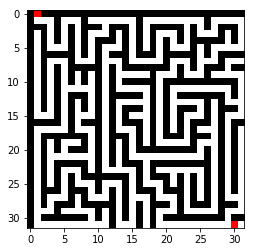

In [15]:
def update_pos(direct, x, y):
    if direct == 0:
        return (x+1,y)
    elif direct == 1:
        return (x, y+1)
    elif direct == 2:
        return (x-1, y)
    else:
        return (x, y - 1)


def carve(maze, x, y, height, width):
    direction = random.randint(0,4)
    count = 0
    while count < 4:
        (x1, y1) = update_pos(direction, x, y)
        (x2, y2) = update_pos(direction, x1, y1)
        if x2 > 0 and x2 < width and y2 > 0 and y2 < height:
            if maze[y1,x1] == 1 and maze[y2,x2] == 1:
                maze[y1, x1] = 0
                maze[y2, x2] = 0
                carve(maze, x2, y2, height, width)
        count = count + 1
        direction = (direction + 1) % 4

def writeImage(a):
    out = PIL.Image.new('RGB', a.shape, (255,255,255))
    d = ImageDraw.Draw(out)

    (height, width) = a.shape
    for x in range(height):
        for y in range(width):
            if a[y,x] == 0:
                d.point([x,y], fill=(255,255,255))
            else:
                d.point([x,y], fill=(0,0,0))
    d.point([1,0], fill=(255,0,0))
    d.point([width - 2, height - 1], fill=(255,0,0))
    return out

def generate(width, height):
    if width < 2 or height < 2:
        raise "Maze needs to be at least 2x2"
    maze = np.ones((height,width))
    maze[1, 1] = 0
    carve(maze, 1,1, height, width)
    maze[0,1] = 0 
    maze[height - 1, width - 2] = 0
    return maze

P.imshow(writeImage(generate(32,32)))

# Maze Solver

In [4]:
import itertools
from scipy import misc
from scipy.sparse.dok import dok_matrix
from scipy.sparse.csgraph import dijkstra

# Defines a translation from 2 coordinates to a single number
def to_index(img, y, x):
    return y * img.shape[1] + x


# Defines a reversed translation from index to 2 coordinates
def to_coordinates(img, index):
    return int(index / img.shape[1]), int(index % img.shape[1])

def get_pred(img, preds, source, target, path):
    if target == source:
        return path
    parent = preds[0][target]
    return get_pred(img, preds, source, parent, path + [to_coordinates(img, parent)])

def solve(img):
    # A sparse adjacency matrix.
    # Two pixels are adjacent in the graph if both are painted.
    adjacency = dok_matrix((img.shape[0] * img.shape[1],
                            img.shape[0] * img.shape[1]), dtype=bool)

    # The following lines fills the adjacency matrix by
    directions = [(1,0), (0,1), (-1, 0), (0,-1)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] != 0:
                continue

            for y_diff, x_diff in directions:
                if i + y_diff < img.shape[0] and j + x_diff < img.shape[1] and i + y_diff > 0 and j + x_diff > 0 and img[i + y_diff, j + x_diff] == 0:
                    adjacency[to_index(img, i, j),
                              to_index(img, i + y_diff, j + x_diff)] = True

    # We chose two arbitrary points, which we know are connected
    source = to_index(img, 0, 1)
    target = to_index(img, img.shape[0] - 1, img.shape[1] - 2)

    # Compute the shortest path between the source and all other points in the image
    _, preds = dijkstra(adjacency, directed=False, indices=[source],
                           unweighted=True, return_predecessors=True)

    return get_pred(img, preds, source, target, [])


In [18]:
def make_unsolvable(maze):
    sol = solve(maze)
    (x,y) = sol[random.randint(0, len(sol))]
    maze[x,y] = 1
    return maze

def to_target(n):
    return to_categorical(n, num_classes=2, dtype='float32')

def mazegenerator(height, width, batch_size=1, batches = 1):
    for i in range(batches):
        if random.randint(0,1) == 0:
            yield(([generate(height, width) for x in range(batch_size)], [to_target(1) for x in range(batch_size)]))
        else:
            yield(([make_unsolvable(generate(height, width)) for x in range(batch_size)], [to_target(0) for x in range(batch_size)]))
    raise StopIteration

gen = mazegenerator(32,32)

while True:
    print(next(gen))

88.88888888888889
([array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])], [array([1., 0.], dtype=float32)])


StopIteration: 

# CNN now

In [ ]:
graph = tf.Graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 32, 32))
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32,32,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.fit_generator(solvable, steps_per_epoch=10, epochs=1)
    model.fit_generator(unsolvable, steps_per_epoch=10, epochs=1)